In [1]:
import numpy
import analysis
import lsst.daf.persistence
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 9)

In [2]:
butler = lsst.daf.persistence.Butler("/lustre/Subaru/SSP/rerun/hsc-1361/20151104/wide")

In [89]:
patches = []
for i in range(0,9):
    for j in range(0,9):
        patches.append("%d,%d" % (i,j))

In [90]:
obj = analysis.ObjectCatalog.read(butler, tracts=(8766,), patches=patches, filters="gri", forced=True, footprints=False, images=False)

In [91]:
def applyMask(catalog, filters):
    flags = ["%s.flags.pixel.edge",
             "%s.flags.pixel.saturated.center",
             "%s.flags.pixel.cr.center",
             "%s.flags.pixel.bad",
             "%s.meas.cmodel.flux.flags",
             "%s.meas.centroid.sdss.flags",]
    allFlags = []
    for b in filters:
        allFlags.extend(s % b for s in flags)
    mask = numpy.logical_and(
        catalog.get("detect.is_primary"),
        numpy.logical_not(numpy.logical_or.reduce([catalog.get(s) for s in allFlags])),
        catalog.get("i.meas.classification.extendedness") == 1.0
    )
    return catalog[mask]
good = applyMask(obj, "gri")

In [99]:
def scatter(cat, name1, name2="mag.kron", c1=None, x=None, z=None, index1=None, binsize=0.5):
    if c1 is None or x is None:
        if index1 is None:
            index1 = slice(None, None)
    if x is None:
        x = cat.i.forced.get(name1)[index1]
    if c1 is None:
        c1 = cat.g.forced.get(name1)[index1] - cat.i.forced.get(name1)[index1]
    y = (c1 - (cat.g.forced.get(name2) - cat.i.forced.get(name2)))
    bin_x = numpy.arange(18.0 + 0.5*binsize, 26.0, binsize)
    bin_y = numpy.zeros(len(bin_x), dtype=float)
    bin_s = numpy.zeros(len(bin_x), dtype=float)
    if z is None:
        z = 'r'
    elif isinstance(z, basestring):
        z = cat.get(z)
    for n, bin_center in enumerate(bin_x):
        mask = numpy.logical_and.reduce([x > bin_center - 0.5*binsize, x <= bin_center + 0.5*binsize,
                                         numpy.isfinite(y)])
        bin_y[n] = numpy.mean(y[mask])
        bin_s[n] = numpy.std(y[mask])
    plt.scatter(x, y, alpha=0.2, linewidth=0, s=4, c=z)
    plt.errorbar(bin_x, bin_y, bin_s, fmt='k-')
    plt.ylabel("g-i (%s) - g-i (%s)" % (name1, name2))
    plt.xlabel("i (%s)" % name1)
    plt.xlim(18.0, 26.0)
    plt.ylim(-0.5, 0.5)

/data1a/ana/products2014/Linux64/ipython/3.2.1/lib/python/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater
/data1a/ana/products2014/Linux64/ipython/3.2.1/lib/python/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in less_equal


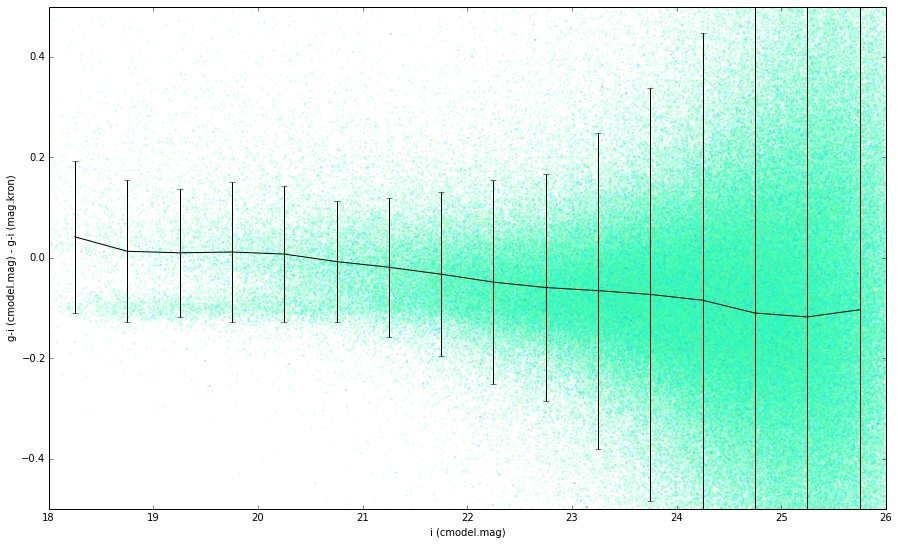

In [102]:
scatter(good, "cmodel.mag", z="i.forced.cmodel.flux.apcorr")

/data1a/ana/products2014/Linux64/ipython/3.2.1/lib/python/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/data1a/ana/products2014/Linux64/ipython/3.2.1/lib/python/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in less_equal


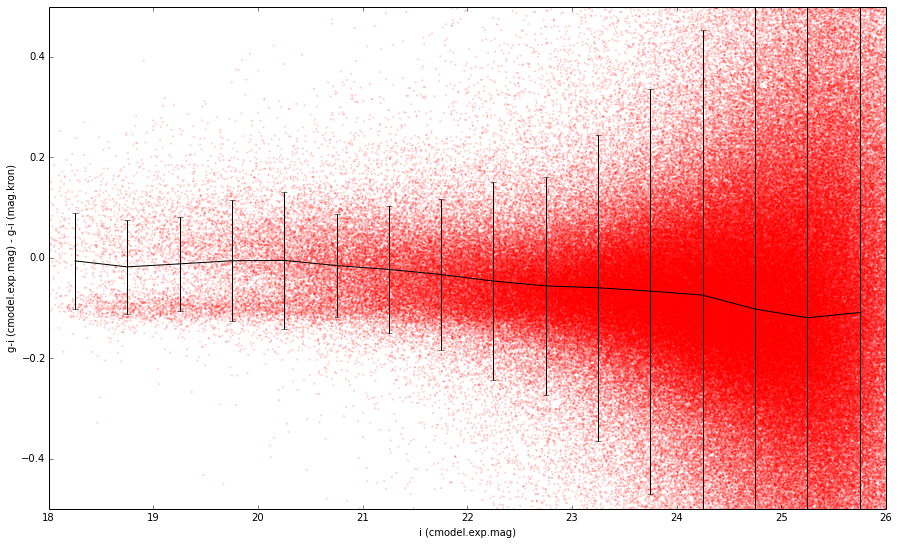

In [94]:
scatter(good, "cmodel.exp.mag")

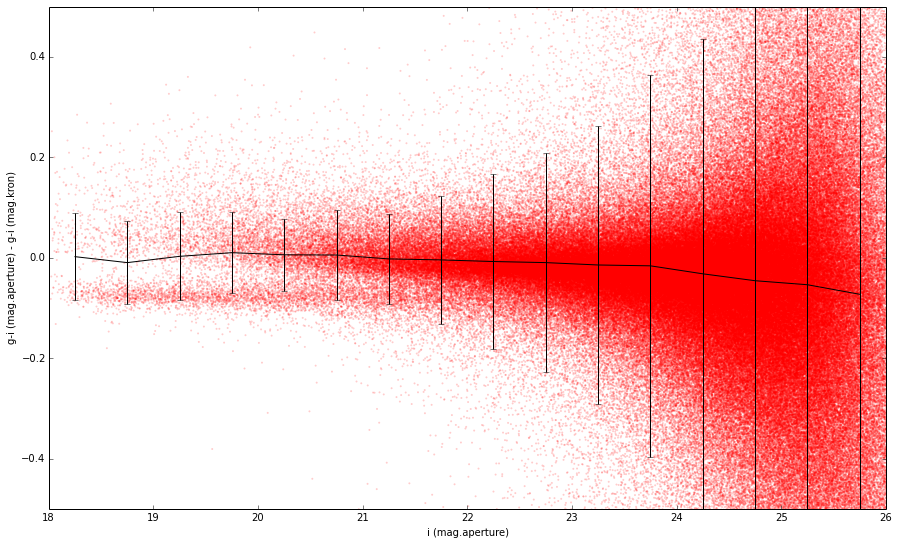

In [95]:
scatter(good, "mag.aperture", index1=(slice(None), 3))

In [87]:
def fixCModel(cat, b):
    fracDev = numpy.zeros(len(cat), dtype=float)
    for f in cat.filters:
        mask = getattr(cat.merge.measurement, f).value
        fracDev[mask] = getattr(cat, f).meas.cmodel.fracDev.value[mask]
    expFlux = 10**(-getattr(cat, b).forced.cmodel.exp.mag/2.5)
    devFlux = 10**(-getattr(cat, b).forced.cmodel.dev.mag/2.5)
    fixedFlux = fracDev * devFlux + (1.0 - fracDev) * expFlux
    return -2.5*numpy.log10(fixedFlux)

/data1a/ana/products2014/Linux64/ipython/3.2.1/lib/python/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/data1a/ana/products2014/Linux64/ipython/3.2.1/lib/python/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in less_equal


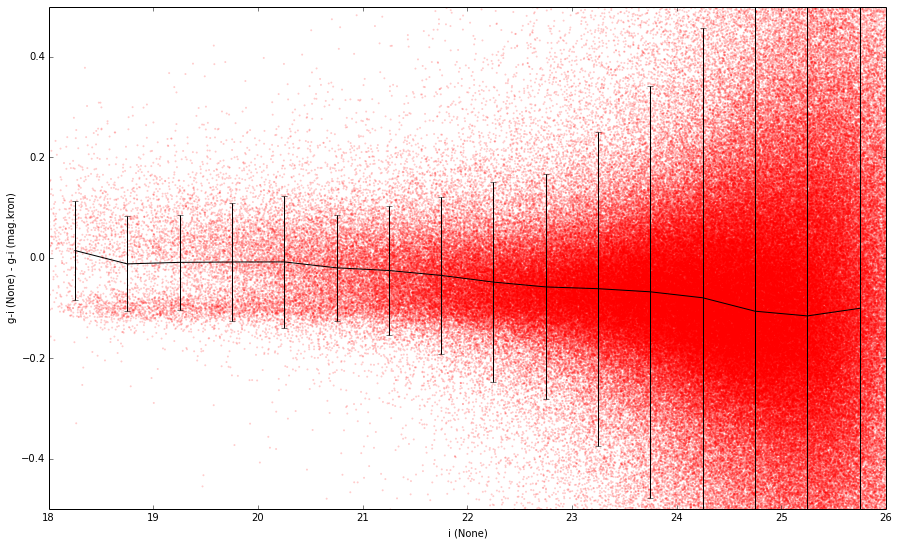

In [96]:
scatter(good, None, c1=fixCModel(good, 'g')-fixCModel(good, 'i'), x=fixCModel(good, 'i'))